# Project title:- 
Advancing Earth Observation Data and ResUNet-Deep Learning Model for Irrigated Area Mapping: The Case of Along the Awash Valley, Ethiopia



# Object Based Image Classification (OBIC) using Random Forest (RF) classifier

This Jupyter notebook demonstrates how to apply OBIC using RF classifier  with the ESA EO-Africa inovation lab cloud computing environment.

**Prerequisites for running this notebook**

Several packages need to be installed and/or imported for running this script:

The `rasterio, skimage, sklearn,and geopandas` modules should be installed first to apply OBIC based RF classifier ;


## Importing the relevant modules 


In [12]:
import rasterio
from rasterio.plot import show
from skimage import io, segmentation, color
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import geopandas as gpd
import numpy as np

## Load RGB image

In [13]:
sentinel_image_path = "/home/eoafrica/Sentinel2_AWbasin/sentinel2_layerstack/stacked_image.tif"
with rasterio.open(sentinel_image_path) as src:
   rgb_image = src.read()

## Load the ground control points (GCP) data from Shapefile

In [14]:
gcp_shapefile_path = "/home/eoafrica/Sentinel2_AWbasin/GCP_LULCawash/lulcgcp.shp"
gcp_data = gpd.read_file(gcp_shapefile_path)

## Extract coordinates and class labels from the GCP data

In [15]:
gcp_coords = np.column_stack((gcp_data.geometry.x, gcp_data.geometry.y))
gcp_labels = gcp_data['class_labe'].values

## Check shapes

In [16]:
print("gcp_coords shape:", gcp_coords.shape)
print("gcp_labels shape:", gcp_labels.shape)

gcp_coords shape: (88, 2)
gcp_labels shape: (88,)


## Convert GCP coordinates to image indices

In [17]:
gcp_indices = np.floor(src.index(gcp_coords[:, 0], gcp_coords[:, 1]))

## Extract RGB values at GCP locations

In [18]:
gcp_rgb_values = rgb_image[:, gcp_indices[1].astype(int), gcp_indices[0].astype(int)].T

## Split data into training and testing sets

In [19]:
X_train, X_test, y_train, y_test = train_test_split(gcp_rgb_values, gcp_labels, test_size=0.2, random_state=42)

## Remove rows with NaN values from the GCP data

In [20]:
valid_indices = ~np.isnan(y_train)
X_train = X_train[valid_indices]
y_train = y_train[valid_indices]

## Train a Random Forest classifier

In [21]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Predict labels for the entire image

In [22]:
rgb_image_reshaped = np.moveaxis(rgb_image, 0, -1)
segments = segmentation.slic(rgb_image_reshaped, compactness=20, n_segments=500)
segmented_image = color.label2rgb(segments, rgb_image_reshaped, kind='avg')

## Extract features for each segment

In [23]:
segment_features = []
for segment_id in np.unique(segments):
    segment_mask = segments == segment_id
    segment_rgb_values = rgb_image_reshaped[segment_mask]
    segment_features.append(np.mean(segment_rgb_values, axis=0))

## Classify segments

In [24]:
predicted_labels = classifier.predict(segment_features)

##  Visualize the classified image

/usr/local/lib/python3.8/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


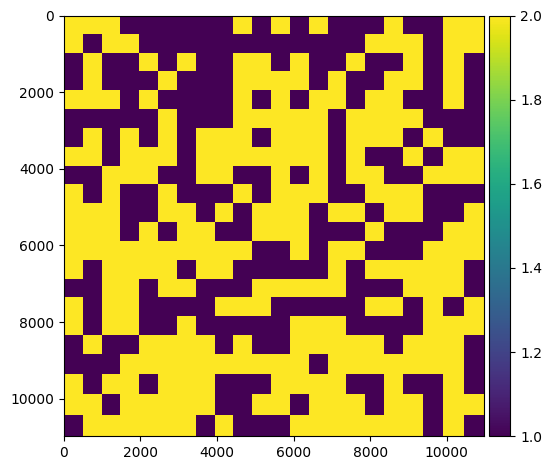

In [25]:
classified_image = np.zeros_like(segments)
for segment_id, label in zip(np.unique(segments), predicted_labels):
    classified_image[segments == segment_id] = label

io.imshow(classified_image)